In [1]:
%load_ext autoreload
%matplotlib widget
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import math
import concurrent.futures
from mpl_toolkits import mplot3d
from matplotlib.widgets import Slider
import tensorflow as tf

%autoreload 1
%aimport jsi

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-10-20 11:34:08.739048: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-20 11:34:08.854528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 11:34:09.708555: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2023-10-20 11:34:11.364552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-20 11:34:11.597755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-20 11:34:11.597830: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
js = np.array([(0.1, 0.1), (0.1, 0.1), (0.1, 0.1), (0.1, 0.1)], dtype=np.float64) # coupling strength
v_js = np.array([0.0, 0.0, 0.0, 0.0], dtype=np.float64) # change in coupling strength per step
phis = np.array([(0, 0), (0, 0), (0, 0), (0, 0)], dtype=np.float64) # coupling phase
# v_phis = [0, 0, 0]

# non-hermitian
js_nh = np.array([(0.0, 0.0), (0, 0), (0, 0), (0, 0)], dtype=np.float64)
v_js_nh = np.array([0.0, 0.0, 0.0, 0], dtype=np.float64) 
phis_nh = np.array([(0, 0), (0, 0), (0, 0), (0, 0)], dtype=np.float64)

# coupling strength of spdc
g = 0.03

# external couplings
# returns the intrinsic and external coupling constants
# defined as functions with two arguments:
# isSig - True if the corresponding nodes is a signaler node
# n - index of the node, ZERO INDEXED, integer expected

# y_0_sig = [-0.49, 0.0, -0.49]
# y_0_idl = [-0.49, 0.0, -0.49]
y_0_sig = [0.1]
y_0_idl = [0.1]
y_ex_sig = [0.1]
y_ex_idl = [0.1]
y_len = [len(y_0_sig),  len(y_0_idl), len(y_ex_sig), len(y_ex_idl)]

# overall period of the unit cell, defaults to the LCM of the array lengths
period = 1
for i in y_len:
    period = abs(period * i) // math.gcd(period, i)

def y_0(isSig, n):
    if isSig:
        return y_0_sig[n % len(y_0_sig)]
    else:
        return y_0_idl[n % len(y_0_idl)]
def y_ex(isSig, n):
    if isSig:
        return y_ex_sig[n % len(y_ex_sig)]
    else:
        return y_ex_idl[n % len(y_ex_idl)]

# number of nodes for signal/idler
nodes = 7

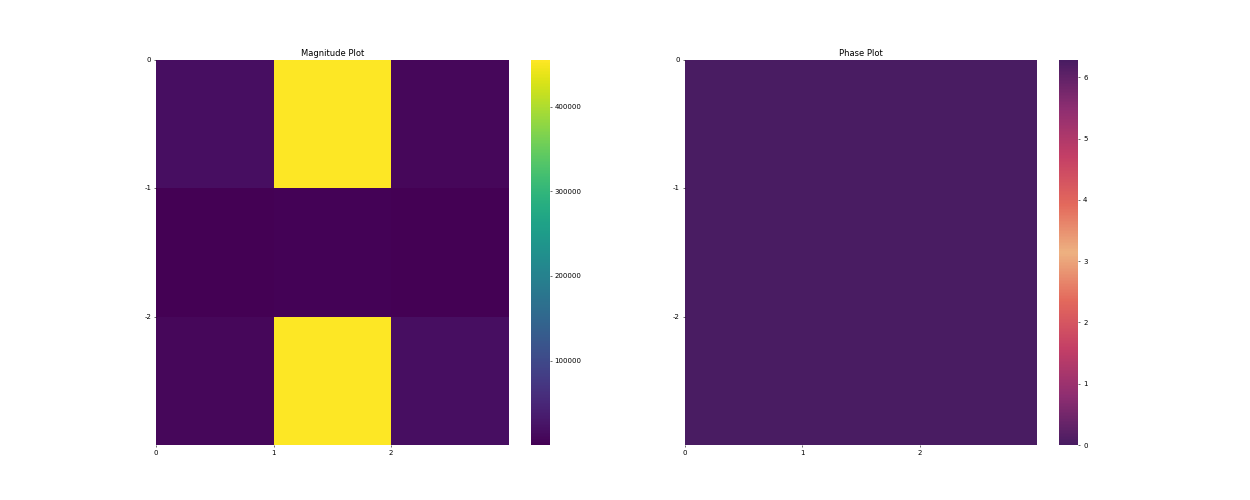

In [73]:
# simple run: generates heatmap for one set of input
result = jsi.jsi(nodes, js, phis, js_nh, phis_nh, g, y_0, y_ex, 0, 0, 0, 0)
result1 = jsi.jsi(nodes, js, phis, js_nh, phis_nh, g, y_0, y_ex, 0, 0, 0, 0, partial={'g':[0]})
result2 = jsi.jsi(nodes, js, phis, js_nh, phis_nh, g, y_0, y_ex, 0, 0, 0, 0, partial={'g':[2]})
try:
    plt.close(fig)
except:
    pass

fig = jsi.pltSect(result1 + result2, 0, 0, nodes, nodes)

In [3]:
mask = {
    's': np.array(
        [[0, 0, 0, 0, 0, 0, 0], 
        [0, 1, 1, 0, 0, 1, 0], 
        [1, 0, 0, 1, 0, 0, 1], 
        [1, 0, 0, 1, 0, 0, 1], 
        [1, 0, 0, 1, 0, 0, 1], 
        [0, 1, 0, 0, 1, 1, 0], 
        [0, 0, 0, 0, 0, 0, 0]]
    ), 
    't': np.array(
        [[0, 0, 0, 0, 0, 0, 0], 
        [1, 0, 0, 0, 0, 0, 0], 
        [1, 0, 0, 0, 0, 0, 0], 
        [1, 1, 1, 1, 1, 1, 1], 
        [1, 0, 0, 0, 0, 0, 0], 
        [1, 0, 0, 0, 0, 0, 0], 
        [0, 0, 0, 0, 0, 0, 0]]
    ), 
    'e': np.array(
        [[0, 0, 0, 0, 0, 0, 0], 
        [1, 1, 1, 1, 1, 1, 1], 
        [1, 0, 0, 1, 0, 0, 1], 
        [1, 0, 0, 1, 0, 0, 1], 
        [1, 0, 0, 0, 0, 0, 1], 
        [1, 0, 0, 0, 0, 0, 1], 
        [0, 0, 0, 0, 0, 0, 0]]
    ), 
    'v': np.array(
        [[0, 0, 0, 0, 0, 0, 0], 
        [1, 1, 1, 1, 1, 0, 0], 
        [0, 0, 0, 0, 0, 1, 0], 
        [0, 0, 0, 0, 0, 0, 1], 
        [0, 0, 0, 0, 0, 1, 0], 
        [1, 1, 1, 1, 1, 0, 0], 
        [0, 0, 0, 0, 0, 0, 0]]
    ), 
    'n': np.array(
        [[0, 0, 0, 0, 0, 0, 0], 
        [1, 1, 1, 1, 1, 1, 1], 
        [0, 0, 1, 0, 0, 0, 0], 
        [0, 0, 0, 1, 0, 0, 0], 
        [0, 0, 0, 0, 1, 0, 0], 
        [1, 1, 1, 1, 1, 1, 1], 
        [0, 0, 0, 0, 0, 0, 0]]
    )
}

iterations:   0%|          | 0/10000 [00:00<?, ?it/s]

(array([0.038 + -0.000i, 0.146 + -0.000i, 0.109 + -0.000i,
       -0.032 + -0.000i, 0.139 + -0.000i, 0.252 + -0.000i,
       0.046 + -0.000i, 0.091 + 0.000i, 0.140 + -0.000i, 0.028 + -0.000i,
       0.026 + -0.000i, 0.103 + 0.000i, 0.210 + 0.000i, 0.171 + -0.000i,
       0.118 + -0.000i, 0.259 + 0.000i, 0.102 + -0.000i, 0.069 + 0.000i,
       0.204 + 0.000i, 0.061 + 0.000i, 0.144 + 0.000i], dtype=complex64), array([0.150 + -0.000i, 0.163 + 0.000i, 0.059 + 0.000i, -0.154 + 0.000i,
       -0.149 + 0.000i, 0.027 + 0.000i, -0.051 + 0.000i, -0.096 + 0.000i,
       -0.059 + 0.000i, 0.074 + 0.000i, 0.127 + 0.000i, 0.096 + 0.000i,
       0.171 + -0.000i, 0.328 + -0.000i, 0.374 + -0.000i, 0.118 + 0.000i,
       0.160 + -0.000i, 0.032 + -0.000i, 0.286 + -0.000i, 0.051 + 0.000i,
       0.109 + 0.000i], dtype=complex64), (0.112574175+0j), (0.011740552+0j), (0.4649543+0j), (0.21174037+0j), (0.06495505+0j))
0.00420326
TARGET: 
--------------------
APPROXIMATION: 


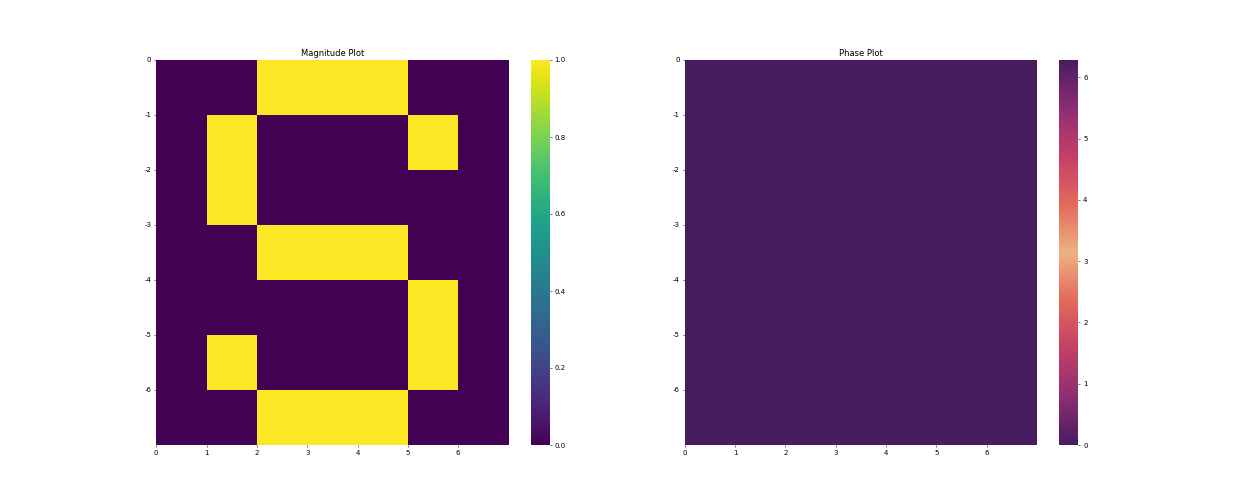

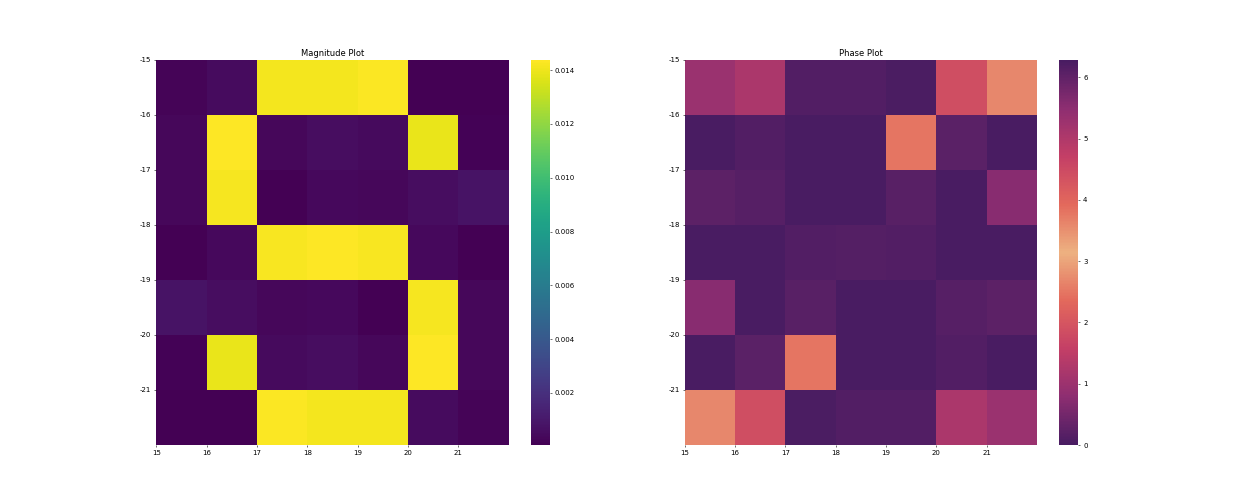

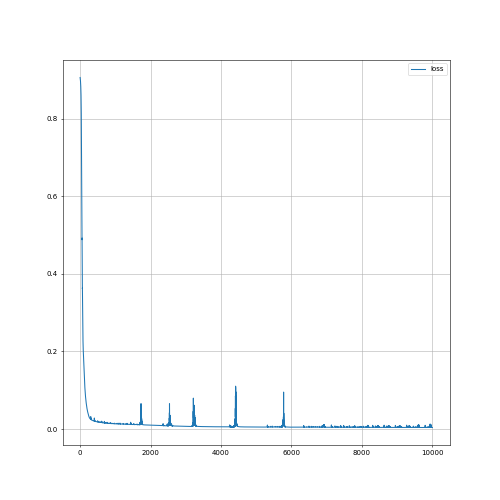

In [5]:
# JSI Approximation

np.set_printoptions(formatter={'complexfloat': lambda x: "{0.real:0.3f} + {0.imag:0.3f}i".format(x)})
nodes = 7
padding = 15 #0.06560147
# padding = 5 # 0.14005375
# padding = 0 # 0.21368206
# target = np.random.uniform(0, 1, (nodes, nodes)) #* np.exp(2j * np.pi * np.random.uniform(0, 1, (nodes, nodes))))
# target = np.abs(np.random.normal(0, 1, (nodes, nodes)))
# target = jsi.jsi(nodes, js, phis, js_nh, phis_nh, g, y_0, y_ex, 0, 0, 0, 0)
target = np.transpose(mask['s'])
pred = jsi.jsi_backprop(nodes, target, EPOCHS=1e4, lr=1e-3, length=nodes+padding-1, padding=padding)
print(pred[0:-1])
print(pred[-1][-1])
try:
    plt.close(fig1)
    plt.close(fig2)
    plt.close(fig3)
    plt.close(fig4)
except:
    pass

js_p = list(zip(np.abs(pred[0]), np.abs(pred[1])))
phis_p = list(zip(np.angle(pred[0]), np.angle(pred[1])))
js_nh_p = list(zip(np.zeros(len(js_p)), np.zeros(len(js_p))))
phis_nh_p = list(zip(np.zeros(len(js_p)), np.zeros(len(js_p))))
loss = pred[-1]
g_p = np.real(pred[2])
# print(js_p, phis_p, g_p)
def y_0_p(isSig, n):
    if isSig:
        return np.real(pred[5])
    else:
        return np.real(pred[6])
def y_ex_p(isSig, n):
    if isSig:
        return np.real(pred[3])
    else:
        return np.real(pred[4])

print("TARGET: ")
print("--------------------")
fig1 = jsi.pltSect(target, 0, 0, nodes, nodes)
print("APPROXIMATION: ")
fig2 = jsi.pltSect(jsi.jsi(nodes + padding * 2, js_p, phis_p, js_nh_p, phis_nh_p, g_p, y_0_p, y_ex_p, 0, 0, 0, 0), padding, padding, nodes, nodes)

fig3, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), dpi=50)
# fig4 = jsi.pltSect(pred[-2], 0, 0, nodes, nodes)
ax.plot(range(len(loss)), loss, label='loss')
ax.legend(loc='best')
ax.grid()

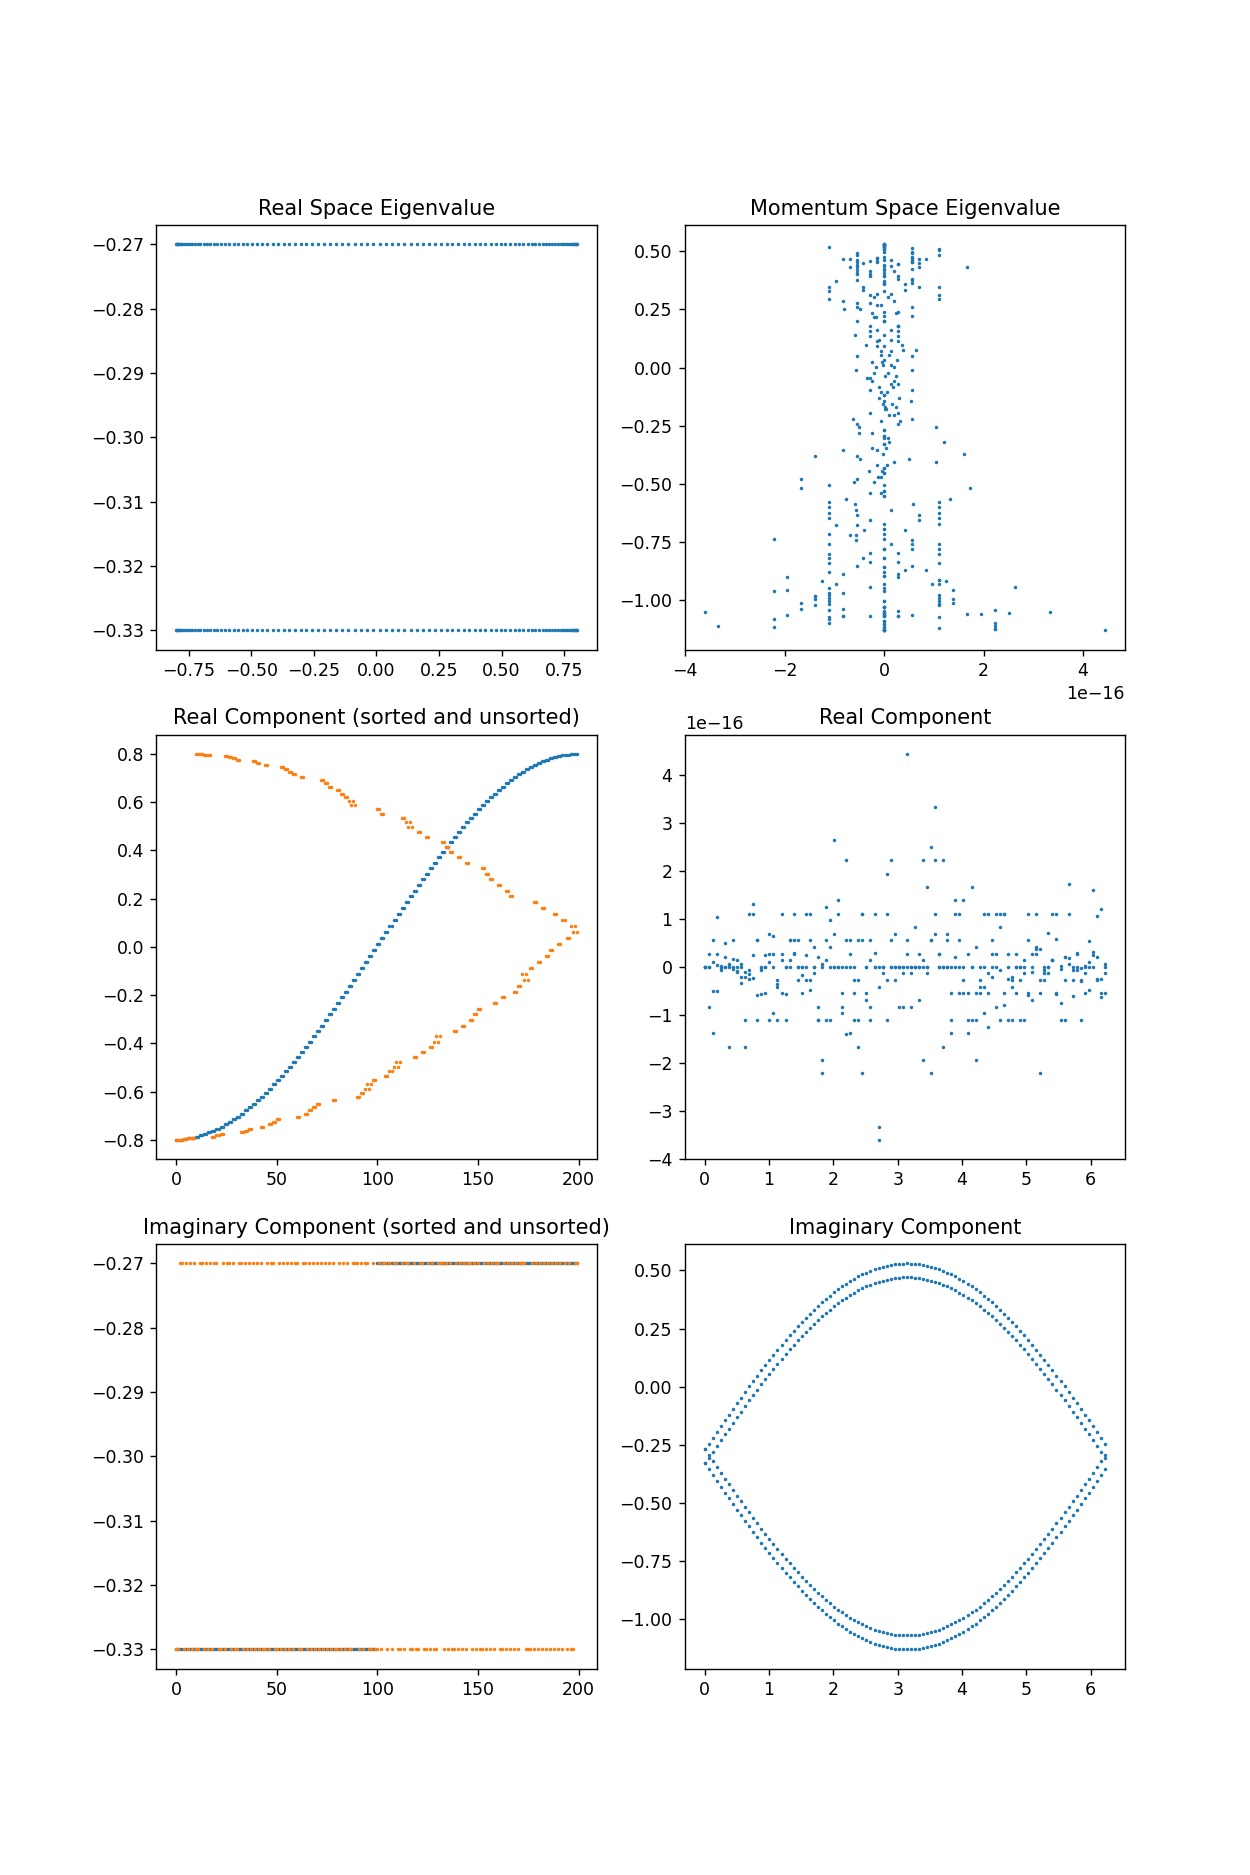

In [111]:
real_space = jsi.eigenRSpace(nodes, js, phis, js_nh, phis_nh, g, y_0, y_ex)
k_space = jsi.eigenKSpace(nodes, js, phis, js_nh, phis_nh, g, y_0, y_ex)
k_space_p_func = jsi.eigenKSpaceP(period, js, phis, js_nh, phis_nh, g, y_0, y_ex)
k_space_p_res = np.concatenate([k_space_p_func(i)[0] for i in np.arange(0, 2 * np.pi, 2 * np.pi / nodes)]).ravel()

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 15), dpi=125)
ax[0][0].scatter(real_space[0].real, real_space[0].imag, s = (1,))
ax[0][0].title.set_text("Real Space Eigenvalue")
# ax[0][1].scatter(k_space[0].real, k_space[0].imag, s = (1,))
ax[0][1].scatter(k_space_p_res.real, k_space_p_res.imag, s = (1,))
ax[0][1].title.set_text("Momentum Space Eigenvalue")
ax[1][0].scatter(range(nodes * 2), np.sort(real_space[0].real), s = (1,))
ax[1][0].scatter(range(nodes * 2), real_space[0].real, s = (1,))
ax[1][0].title.set_text("Real Component (sorted and unsorted)")
ax[2][0].scatter(range(nodes * 2), np.sort(real_space[0].imag), s = (1,))
ax[2][0].scatter(range(nodes * 2), real_space[0].imag, s = (1,))
ax[2][0].title.set_text("Imaginary Component (sorted and unsorted)")

ax[1][1].scatter(np.repeat(np.arange(0, 2 * np.pi, 2 * np.pi / nodes), period * 2), k_space_p_res.real, s=(1, ))
# ax[1][1].scatter(np.repeat(range(nodes), 2), np.sort(k_space[0].real), s = (1,))
# ax[1][1].scatter(jsi.eigSort(k_space), k_space[0].real, s = (1,))
ax[1][1].title.set_text("Real Component")
ax[2][1].scatter(np.repeat(np.arange(0, 2 * np.pi, 2 * np.pi / nodes), period * 2), k_space_p_res.imag, s=(1, ))
# ax[2][1].scatter(range(nodes * 2), np.sort(k_space[0].imag), s = (1,))
# ax[2][1].scatter(range(nodes * 2), k_space[0].imag, s = (1,))
ax[2][1].title.set_text("Imaginary Component")

# print(np.concatenate([k_space_p(i)[0] for i in np.arange(0, 2 * np.pi, 2 * np.pi / nodes)]).ravel())

# analytical solution for 1d unit cell
# E_p = lambda k: 1/2 * (-1j * (y_0(True, 0) + y_ex(True, 0)) + np.emath.sqrt(2 * np.power(js[0], 2) * (np.cos(2 * k) + 1) - 4 * np.power(g, 2)))
# E_m = lambda k: 1/2 * (-1j * (y_0(True, 0) + y_ex(True, 0)) - np.emath.sqrt(2 * np.power(js[0], 2) * (np.cos(2 * k) + 1) - 4 * np.power(g, 2)))

# ax[0][1].scatter(E_p(np.arange(0, 2 * np.pi, 2 * np.pi / nodes)).real, E_p(np.arange(0, 2 * np.pi, 2 * np.pi / nodes)).imag, s=(1, ))
# ax[0][1].scatter(E_m(np.arange(0, 2 * np.pi, 2 * np.pi / nodes)).real, E_m(np.arange(0, 2 * np.pi, 2 * np.pi / nodes)).imag, s=(1, ))

In [3]:
# Calculates real space eigenvalues and k-space energy bands when trivial nodes are gradually changed to topological modes
# If kernel crashes try decreasing the worker count

range_arr = np.arange(-1, 1, 0.01)
output_rr = [None] * len(range_arr)
output_kr = [None] * len(range_arr)
output_ri = [None] * len(range_arr)
output_ki = [None] * len(range_arr)

period = 4

def eBand(i):
    y_0_se =  abs(i)
    y_0_so = abs(i)
    y_0_ie = abs(i)
    y_0_io = abs(i)
    y_ex_0 = abs(i)
    y_ex_1 = -1 * i
    y_ex_2 = -1 * abs(i)
    y_ex_3 = i
    
    y_0_sig = [abs(i), abs(i), abs(i), abs(i)]
    y_0_idl = [abs(i), abs(i), abs(i), abs(i)]
    y_ex_sig = [abs(i), -1 * i, -1 * abs(i), i]
    y_ex_idl = list(reversed([abs(i), -1 * i, -1 * abs(i), i]))

    # overall period of the unit cell, defaults to the LCM of the array lengths

    def y_0(isSig, n):
        if isSig:
            return y_0_sig[n % period % len(y_0_sig)]
        else:
            return y_0_idl[n % period % len(y_0_idl)]
    def y_ex(isSig, n):
        if isSig:
            return y_ex_sig[n % period % len(y_ex_sig)]
        else:
            return y_ex_idl[n % period % len(y_ex_idl)]

    real_space = jsi.eigenRSpace(nodes, js, phis, js_nh, phis_nh, g, y_0, y_ex)
    # k_space = jsi.eigenKSpace(nodes, js, phis, js_nh, phis_nh, g, y_0, y_ex)
    k_space_p_func = jsi.eigenKSpaceP(period, js, phis, js_nh, phis_nh, g, y_0, y_ex)
    k_space_p_res = np.concatenate([k_space_p_func(j)[0] for j in np.arange(0, 2 * np.pi, 2 * np.pi / nodes)]).ravel()

    return (real_space[0], k_space_p_res)

with concurrent.futures.ThreadPoolExecutor(max_workers=24) as pool:
    fut_band = {pool.submit(eBand, j): i[0] for i, j in np.ndenumerate(range_arr)}
    for future in concurrent.futures.as_completed(fut_band):
        result = future.result()
        output_rr[fut_band[future]] = result[0].real
        output_kr[fut_band[future]] = result[1].real
        output_ri[fut_band[future]] = result[0].imag
        output_ki[fut_band[future]] = result[1].imag


In [131]:
range_arr = np.arange(-1, 1, 0.01)
output_rr = [None] * len(range_arr)
output_kr = [None] * len(range_arr)
output_ri = [None] * len(range_arr)
output_ki = [None] * len(range_arr)

period = 2

def eBand(i):
    js = np.array([(0.0, -0.4 * (1 + i)), (0.0, 0.4 * (1 + i)), (0.0, -0.0), (0.0, 0.0)]) # coupling strength
    js_nh = np.array([(0.0, 0.4 * (1 - i)), (0.0, 0.4 * (1 - i)), (0.0, -0.0), (0.0, 0.0)])
    real_space = jsi.eigenRSpace(nodes, js, phis, js_nh, phis_nh, g, y_0, y_ex)
    # k_space = jsi.eigenKSpace(nodes, js, phis, js_nh, phis_nh, g, y_0, y_ex)
    k_space_p_func = jsi.eigenKSpaceP(period, js, phis, js_nh, phis_nh, g, y_0, y_ex)
    k_space_p_res = np.concatenate([k_space_p_func(j)[0] for j in np.arange(0, 2 * np.pi, 2 * np.pi / nodes)]).ravel()

    return (real_space[0], k_space_p_res)

with concurrent.futures.ThreadPoolExecutor(max_workers=24) as pool:
    fut_band = {pool.submit(eBand, j): i[0] for i, j in np.ndenumerate(range_arr)}
    for future in concurrent.futures.as_completed(fut_band):
        result = future.result()
        output_rr[fut_band[future]] = result[0].real
        output_kr[fut_band[future]] = result[1].real
        output_ri[fut_band[future]] = result[0].imag
        output_ki[fut_band[future]] = result[1].imag


0

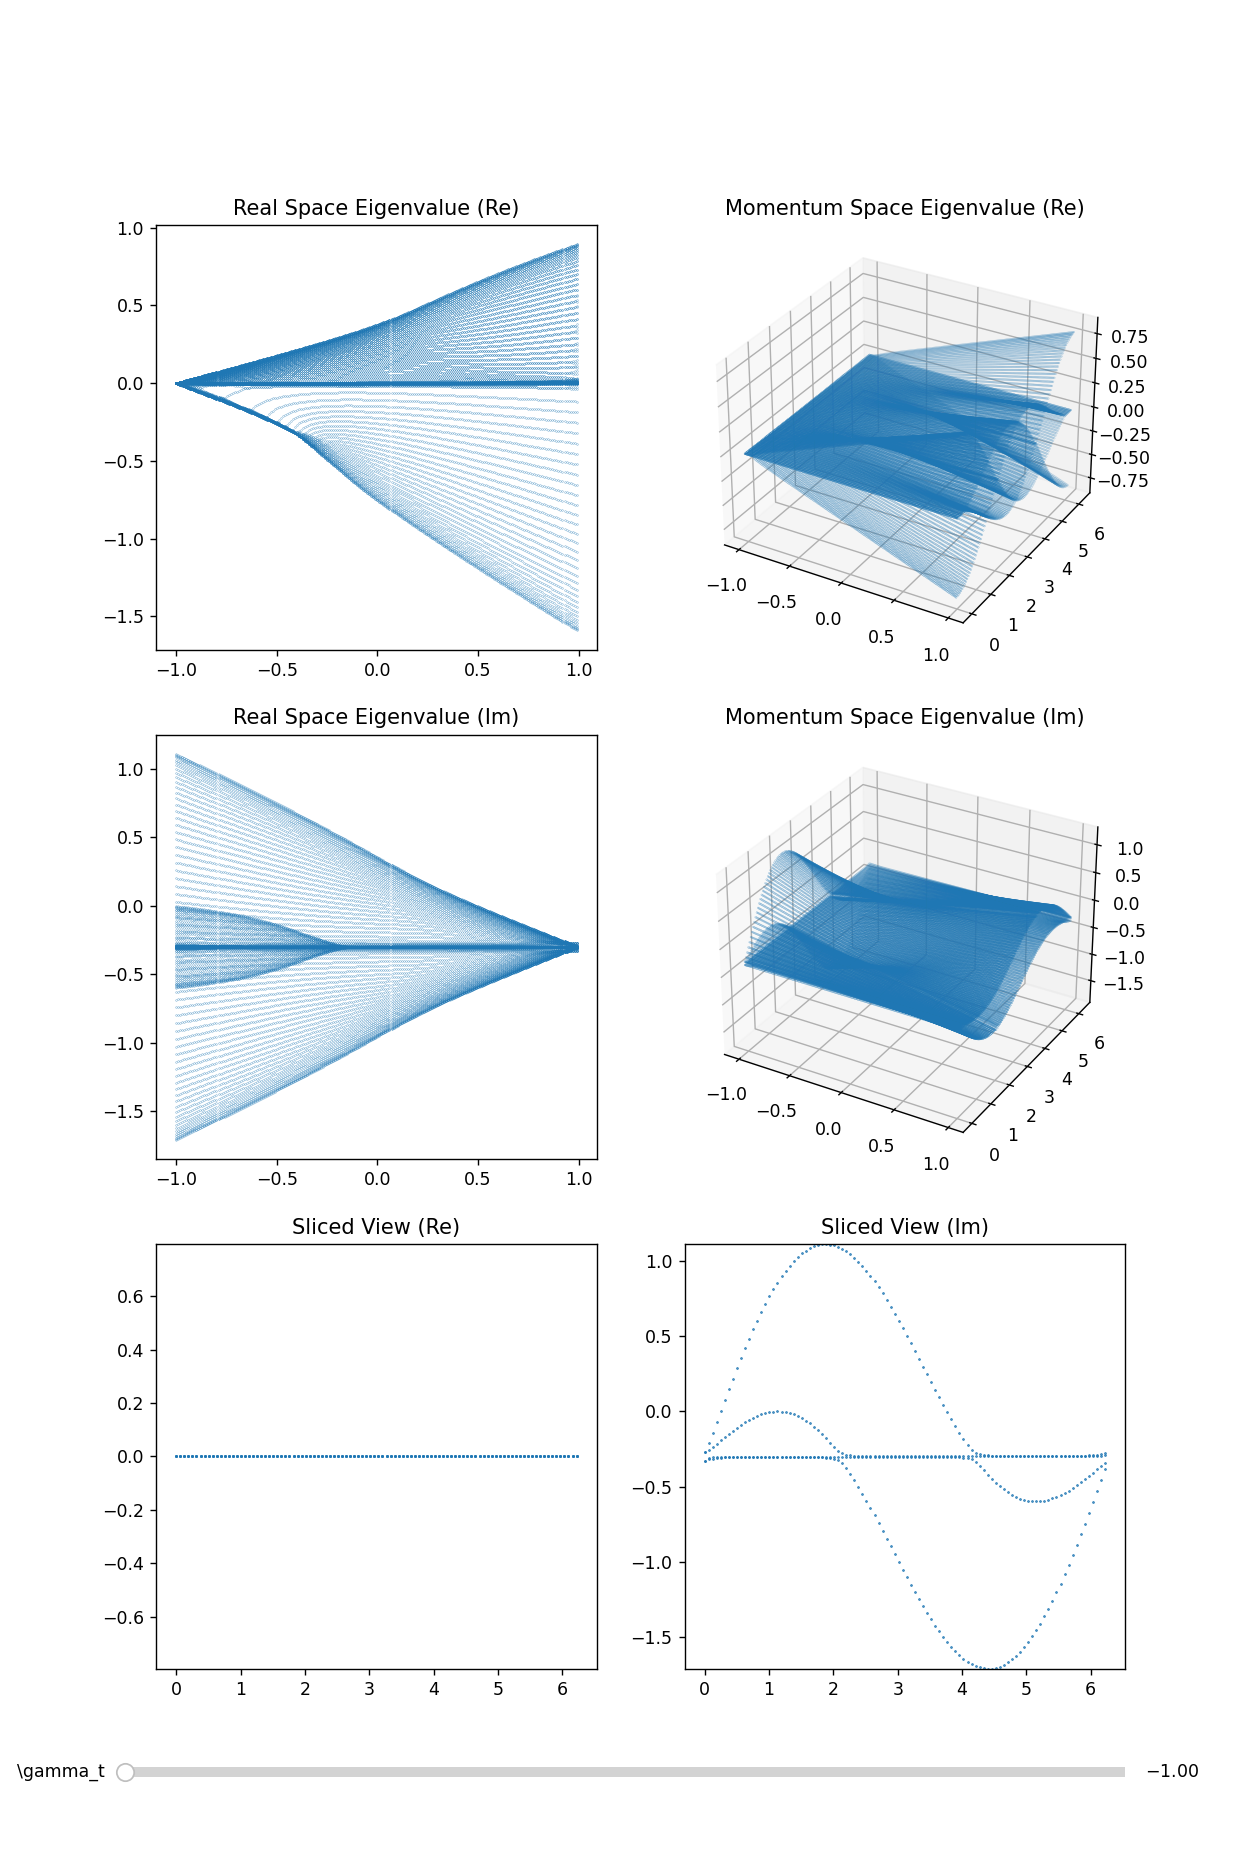

In [132]:
# Visualization for the previous code block

plt.close('all')
fig = plt.figure(figsize=(10,15), dpi=125)
# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), dpi=300)

ax = fig.add_subplot(3, 2, 1)
ax.scatter(np.repeat(range_arr, nodes * 2), np.concatenate(output_rr).ravel(), s = (0.1,), marker='.')
ax.title.set_text("Real Space Eigenvalue (Re)")

# ax[0][1] = plt.axes(projection='3d')
ax = fig.add_subplot(3, 2, 2, projection='3d')
ax.scatter3D(np.repeat(range_arr, nodes * period * 2), np.tile(np.repeat(np.arange(0, 2 * np.pi, 2 * np.pi / nodes), period * 2), len(range_arr)), np.concatenate(output_kr).ravel(), s = (0.1,), marker='.')
ax.title.set_text("Momentum Space Eigenvalue (Re)")

ax = fig.add_subplot(3, 2, 3)
ax.scatter(np.repeat(range_arr, nodes * 2), np.concatenate(output_ri).ravel(), s = (0.1,), marker='.')
ax.title.set_text("Real Space Eigenvalue (Im)")

# ax[1][1] = plt.axes(projection='3d')
ax = fig.add_subplot(3, 2, 4, projection='3d')
ax.scatter3D(np.repeat(range_arr, nodes * period * 2), np.tile(np.repeat(np.arange(0, 2 * np.pi, 2 * np.pi / nodes), period * 2), len(range_arr)), np.concatenate(output_ki).ravel(), s = (0.1,), marker='.')
ax.title.set_text("Momentum Space Eigenvalue (Im)")

ax = fig.add_subplot(3, 2, 5)
rl = ax.scatter(np.repeat(np.arange(0, 2 * np.pi, 2 * np.pi / nodes), period * 2), output_kr[0], s = (1,), marker='.')
ax.set_ylim([np.min(output_kr), np.max(output_kr)])
ax.title.set_text("Sliced View (Re)")

ax = fig.add_subplot(3, 2, 6)
im = ax.scatter(np.repeat(np.arange(0, 2 * np.pi, 2 * np.pi / nodes), period * 2), output_ki[0], s = (1,), marker='.')
ax.set_ylim([np.min(output_ki), np.max(output_ki)])
ax.title.set_text("Sliced View (Im)")

s_ax = fig.add_axes([0.1, 0.05, 0.8, 0.01])
s = Slider(
    s_ax, '\gamma_t', range_arr[0], range_arr[-1],
    valinit=range_arr[0], valstep=range_arr,
    color="green"
)

def update(val):
    print('entered')
    gamma = s.val
    rl.set_offsets(np.column_stack((np.repeat(np.arange(0, 2 * np.pi, 2 * np.pi / nodes), period * 2),output_kr[np.where(np.isclose(range_arr, gamma))[0][0]])))
    im.set_offsets(np.column_stack((np.repeat(np.arange(0, 2 * np.pi, 2 * np.pi / nodes), period * 2),output_ki[np.where(np.isclose(range_arr, gamma))[0][0]])))
    fig.canvas.draw_idle()

s.on_changed(update)

In [8]:
def genProbMtrx(nodes):
    output = np.random.rand(nodes, nodes)
    return output / np.sum(output)


In [9]:
# loss function of the result

def loss(target, input):
    if not input.shape == target.shape:
        raise IndexError('Loss evaluation: Input dimension mismatch')
    else:
        target_flat = np.concatenate(target).ravel()
        input_flat = np.concatenate(input).ravel()
        return 1 - np.abs(target_flat.conjugate().dot(input_flat)) / np.sqrt(target_flat.conjugate().dot(target_flat) * input_flat.conjugate().dot(input_flat))

In [5]:
def flatten_input(nodes, input):
                       js = [(input[0], input[1]), (input[2], input[3]), (input[4], input[5])]
                       phis = [(input[6], input[7]), (input[8], input[9]), (input[10], input[11])]
                       js_nh = [(input[12], input[13]), (input[14], input[15]), (input[16], input[17])]
                       phis_nh = [(input[18], input[19]), (input[20], input[21]), (input[22], input[23])]
                       def y_0(n, isSig):
                           return input[24] if isSig else input[25]
                       def y_ex(n, isSig):
                           return input[26] if isSig else input[27]
                       return jsi.jsi(nodes, js, phis, js_nh, phis_nh, input[28], y_0, y_ex, 0, 0, 0, 0)

In [10]:
rand = np.random.rand(29)
# target = genProbMtrx(nodes)
target = flatten_input(nodes, rand)
def func_to_minimize(input):
    try:
        result = flatten_input(nodes, input);
    except:
        return np.inf
    return loss(target, result)

x0 = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.1, 0.5, 0.5, g])
res = sp.optimize.minimize(func_to_minimize, x0, method='BFGS',
               options={'disp': True})
print(res.x)
print(rand)

C:\Users\ha942\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\Users\ha942\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_linesearch.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
C:\Users\ha942\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_differentiable_functions.py:243: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
C:\Users\ha942\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_linesearch.py:480: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
C:\Users\ha942\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_linesearch.py:482: ComplexWarning: Casting complex values to re

         Current function value: 0.220715
         Iterations: 15
         Function evaluations: 1691
         Gradient evaluations: 56
[ 5.80305077e-01  6.20391334e-01  6.11660484e-01  2.53542251e-01
  5.00094801e-01  5.01662591e-01  5.33524101e-02  0.00000000e+00
 -2.18659103e-03  0.00000000e+00  6.37346337e-02  0.00000000e+00
  7.33069851e-02 -8.77522456e-02  2.52853219e-02 -1.26445791e-04
  1.21028208e-02 -1.84157356e-02 -2.65293095e-02  0.00000000e+00
 -7.91906969e-03  0.00000000e+00  1.19402466e-03  0.00000000e+00
  1.24070556e-02  4.62769134e-02  4.44958145e-01  4.13731257e-01
  2.05585182e-01]
[0.05149544 0.68843408 0.9382104  0.94092251 0.58289633 0.2499441
 0.99323399 0.87810724 0.15608114 0.47645455 0.51026141 0.11435698
 0.66603943 0.52266795 0.86143034 0.19382739 0.85098875 0.64863544
 0.58515945 0.09808398 0.71541054 0.59143113 0.51467342 0.06731678
 0.74213933 0.17420067 0.72443281 0.95550882 0.59181061]


In [12]:
# creates a series of figures and save under a subdirectory

# Create the subdirectory if it doesn't exist
subdirectory = "jsi_output_j1_0.7"
os.makedirs(subdirectory, exist_ok=True)

for i in np.arange(0, 1, 0.1):
    result = jsi.jsi(nodes, js + v_js * i, phis, js_nh + v_js_nh * i, phis_nh, g, y_0, y_ex, 0, 0, 0, 0)
    # Save the plot to the subdirectory
    diag = np.array([], dtype = np.complex_)
    adiag = np.array([], dtype = np.complex_)
    for j in np.arange(5, nodes - 5, 1):
        index = int(np.round(j))
        diag = np.append(diag, np.abs(result[j][j]))
        adiag = np.append(adiag, np.abs(result[nodes - j][j]))
    filename_h = os.path.join(subdirectory, 'heat_j1_nh_' + "{:.2f}".format(i*0.7) + '.png')
    filename = os.path.join(subdirectory, 'j1_nh_' + "{:.2f}".format(i*0.7) + '.png')
    
    
    jsi.pltSect(result.copy(), 5, 5, nodes - 10, nodes - 10)
    plt.savefig(filename_h)
    plt.close()

    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].plot(diag)
    ax[1].plot(adiag)
    plt.savefig(filename)
    plt.close()

C:\Users\ha942\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\ha942\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\ha942\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\ha942\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\ha942\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(

In [4]:
def mkMtrx (nodes, js, phis, js_nh, phis_nh, g, y_0, y_ex, w):
    output = np.zeros([nodes, nodes], dtype = np.complex_)
    cpl_a = []#np.zeros(3, dtype = np.complex_)
    cpl_s = []#np.zeros(3, dtype = np.complex_)

    # Assemble coupling constants
    for i in range(len(js)):
        cpl_a.append( (js[i][0] * np.exp(1j * phis[i][0]) + js_nh[i][0] * np.exp(1j * phis_nh[i][0]), js[i][1] * np.exp(1j * phis[i][0]) + js_nh[i][1] * np.exp(1j * phis_nh[i][0])) )
        cpl_s.append( (js[i][0] * np.exp(1j * phis[i][0]) - js_nh[i][0] * np.exp(1j * phis_nh[i][0]), js[i][1] * np.exp(1j * phis[i][0]) - js_nh[i][1] * np.exp(1j * phis_nh[i][0])) )
        
    # Signal side
    for i in range(nodes):
        row = nodes - i - 1
        # output[row][nodes + i] = 1j * g
        output[row][row] = (y_0(True, i) + y_ex(True, i)) / 2 - 1j * w

        for k in range(len(js)):
            if (i - k - 1 >= 0):
                output[row][row + k + 1] = 1j * cpl_a[k][0] / 2
            if (i + k + 1 < nodes):
                output[row][row - k - 1] = 1j * cpl_s[k][0].conj() / 2

    # Idler side
    # for i in range(nodes):
    #     row = nodes + i
    #     # output[row][nodes - i - 1] = -1j * g
    #     output[row][row] = (y_0(False, i) + y_ex(False, i)) / 2 - 1j * w

    #     for k in range(len(js)):
    #         if (i - k - 1 >= 0):
    #             output[row][row - k - 1] = -1j * cpl_s[k][1] / 2
    #         if (i + k + 1 < nodes):
    #             output[row][row + k + 1] = -1j * cpl_a[k][1].conj() / 2
    
    return output

In [8]:
def genDataSet(nodes, n_train, n_test):
    result = np.zeros((nodes * nodes, n_train + n_test), dtype=np.float64)
    input = np.zeros((25, n_train + n_test), dtype=np.float64)
    
    i = 0
    while i < (n_train + n_test):
        js = [(np.random.uniform(0, 10), np.random.uniform(0, 10)) for i in range(5)]
        phis = [(np.random.uniform(0, 2*np.pi), np.random.uniform(0, 2*np.pi)) for i in range(5)]
        # v_phis = [0, 0, 0]
        
        # non-hermitian
        # js_nh = [(np.random.uniform(0, 10), np.random.uniform(0, 10)) for i in range(5)]
        # phis_nh = [(np.random.uniform(0, 2*np.pi), np.random.uniform(0, 2*np.pi)) for i in range(5)]
        js_nh = np.array([(0.0, 0.0), (0, 0), (0, 0), (0, 0), (0, 0)], dtype=np.float64)
        phis_nh = np.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0)], dtype=np.float64)
        
        # coupling strength of spdc
        g = np.random.uniform(0, 0.1)

        y_0_sig = np.random.uniform(0, 1)
        y_0_idl = np.random.uniform(0, 1)
        y_ex_sig = np.random.uniform(0, 1)
        y_ex_idl = np.random.uniform(0, 1)

        def y_0(isSig, n):
            if isSig:
                return y_0_sig
            else:
                return y_0_idl
        def y_ex(isSig, n):
            if isSig:
                return y_ex_sig
            else:
                return y_ex_idl
        # result[:, i] = jsi.jsi(nodes, js, phis, js_nh, phis_nh, g, y_0, y_ex, 0, 0, 0, 0).flatten()
        try:
            result[:, i] = jsi.jsi(nodes, js, phis, js_nh, phis_nh, g, y_0, y_ex, 0, 0, 0, 0).flatten()
        except Exception as e:
            print(str(e) + " on iteration i = " + str(i))
            continue

        input[0:10:2, i] = [x[0] for x in js]
        input[1:10:2, i] = [x[1] for x in js]
        input[10:20:2, i] = [x[0] for x in phis]
        input[11:20:2, i] = [x[1] for x in phis]
        # input[20:30:2, i] = [x[0] for x in js_nh]
        # input[21:30:2, i] = [x[1] for x in js_nh]
        # input[30:40:2, i] = [x[0] for x in phis_nh]
        # input[31:40:2, i] = [x[1] for x in phis_nh]
        input[20, i] = g
        input[21, i] = y_0_sig
        input[22, i] = y_0_idl
        input[23, i] = y_ex_sig
        input[24, i] = y_ex_idl
        # print("Data set #" + str(i) + " generated")
        i += 1

    data = {'x_train' : result[:, 0:n_train]
           , 'y_train' : input[:, 0:n_train]
           , 'x_test' : result[:, n_train : n_train + n_test]
           , 'y_test' : input[:, n_train : n_train + n_test]
           }
    np.savez('dataset' + str(nodes) + 'x' +str(nodes) + 'x(' + str(n_train) + '+' + str(n_test) + ').npz', **data)

In [9]:
genDataSet(20, 1000, 100)

2023-10-10 12:45:54.285718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 12:45:54.285818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 12:45:54.285838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 12:45:55.020786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 12:45:55.020887: I tensorflow/compile

Data set #0 generated
Data set #1 generated
Data set #2 generated
Data set #3 generated
Data set #4 generated
Data set #5 generated
Data set #6 generated
Data set #7 generated
Data set #8 generated
Data set #9 generated
Data set #10 generated
Data set #11 generated
Data set #12 generated
Data set #13 generated
Data set #14 generated
Data set #15 generated
Data set #16 generated
Data set #17 generated
Data set #18 generated
Data set #19 generated
Data set #20 generated
Data set #21 generated
Data set #22 generated
Data set #23 generated
Data set #24 generated
Data set #25 generated
Data set #26 generated
Data set #27 generated
Data set #28 generated
Data set #29 generated
Data set #30 generated
Data set #31 generated
Data set #32 generated
Data set #33 generated
Data set #34 generated
Data set #35 generated
Data set #36 generated
Data set #37 generated
Data set #38 generated
Data set #39 generated
Data set #40 generated
Data set #41 generated
Data set #42 generated
Data set #43 generate

In [127]:
n = 0.151 + -0.022j
-1j * np.abs(n) * np.exp(1j * np.angle(n)) / 2

(-0.010999999999999998-0.07549999999999998j)